In [10]:
from tensorflow.keras.layers import Add, Dense, Dropout, MultiHeadAttention, LayerNormalization, Layer, Normalization, Softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model,Sequential
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, Callback
from keras.layers import Lambda
import keras.backend as K
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import json
import math
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

## Layer

In [2]:
class PositionalEmbedding(Layer):
    def __init__(self, units, dropout_rate, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)

        self.units = units

        self.projection = Dense(units, kernel_initializer=TruncatedNormal(stddev=0.02))

        self.dropout = Dropout(rate=dropout_rate)

    def build(self, input_shape):
        super(PositionalEmbedding, self).build(input_shape)

        self.position = self.add_weight(
            name="position",
            shape=(1, input_shape[1], self.units),
            initializer=TruncatedNormal(stddev=0.02),
            trainable=True,
        )

    def call(self, inputs, training):
        x = self.projection(inputs)
        x = x + self.position

        return self.dropout(x, training=training)

class Encoder(Layer):
    def __init__(
        self, embed_dim, fc_dim, num_heads, dropout_rate, attention_dropout_rate, **kwargs
    ):
        super(Encoder, self).__init__(**kwargs)

        self.mha = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=attention_dropout_rate,
            kernel_initializer=TruncatedNormal(stddev=0.02),
        )

        self.dense_0 = Dense(
            units=fc_dim,
            activation="gelu",
            kernel_initializer=TruncatedNormal(stddev=0.02),
        )
        self.dense_1 = Dense(
            units=embed_dim, kernel_initializer=TruncatedNormal(stddev=0.02)
        )

        self.dropout_0 = Dropout(rate=dropout_rate)
        self.dropout_1 = Dropout(rate=dropout_rate)

        self.norm_0 = LayerNormalization(epsilon=1e-5)
        self.norm_1 = LayerNormalization(epsilon=1e-5)

        self.add_0 = Add()
        self.add_1 = Add()

    def call(self, inputs, training):
        # Attention block
        x = self.mha(
            query=inputs,
            value=inputs,
            key=inputs,
            training=training,
        )
        x = self.norm_0(x)
        x = self.dropout_0(x, training=training)
        x = self.add_0([x, inputs])


        # MLP block
        y = self.dense_0(x)
        y = self.dense_1(y)
        y = self.norm_1(y)
        y = self.dropout_1(y, training=training)


        return self.add_1([x, y])

## Model

In [3]:
class Transformer(Model):
    def __init__(
        self,
        num_layers,
        embed_dim,
        fc_dim,
        num_heads,
        num_classes,
        dropout_rate,
        attention_dropout_rate,
        **kwargs
    ):
        super(Transformer, self).__init__(**kwargs)

        # Input (normalization of RAW measurements)
        self.input_norm = Normalization()

        # Input
        self.pos_embs = PositionalEmbedding(embed_dim, dropout_rate)

        # Encoder
        self.e_layers = [
            Encoder(embed_dim, fc_dim, num_heads, dropout_rate, attention_dropout_rate)
            for _ in range(num_layers)
        ]

        # Output
        self.norm = LayerNormalization(epsilon=1e-5)
        self.final_layer = Dense(num_classes, kernel_initializer="zeros")

    def call(self, inputs, training):
        x = self.input_norm(inputs)
        x = self.pos_embs(x, training=training)

        for layer in self.e_layers:
            x = layer(x, training=training)

        x = self.norm(x)
        x = self.final_layer(x)

        return x

## Loss

In [4]:
def smoothed_sparse_categorical_crossentropy(label_smoothing: float = 0.0):
    def loss_fn(y_true, y_pred):
        num_classes = tf.shape(y_pred)[-1]
        y_true = tf.one_hot(y_true, num_classes)

        loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True, label_smoothing=label_smoothing)
        return tf.reduce_mean(loss)

    return loss_fn

## LR Scheduler

In [5]:
def cosine_schedule(base_lr, total_steps, warmup_steps):
    def step_fn(epoch):
        lr = base_lr
        epoch += 1

        progress = (epoch - warmup_steps) / float(total_steps - warmup_steps)
        progress = tf.clip_by_value(progress, 0.0, 1.0)

        lr = lr * 0.5 * (1.0 + tf.cos(math.pi * progress))

        if warmup_steps:
            lr = lr * tf.minimum(1.0, epoch / warmup_steps)

        return lr

    return step_fn

## Dataset

In [209]:
# load dataset
dataset = np.load('pdiot-data/dataset.npz')
X = dataset['datapoints']
y = dataset['labels']

X, X_test, y, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1892493, stratify=y
)

print(X.shape, y.shape)
print(X_test.shape, y_test.shape)

(44106, 50, 6) (44106, 50)
(4901, 50, 6) (4901, 50)


## Train

In [8]:
def train(config, X, y, checkpoint_filepath):

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1892493)
    cvscores = []
    y = y[:, 0]
    idx = 0

    for train, val in kfold.split(X, y):
        # Generate new model
        model = Transformer(
              num_layers=config['num_layers'],
              embed_dim=config['embed_dim'],
              fc_dim=config['fc_dim'],
              num_heads=config['num_heads'],
              num_classes=config['num_classes'],
              dropout_rate=config['dropout_rate'],
              attention_dropout_rate=config['attention_dropout_rate'],
        )

        # adapt on training dataset - must be before model.compile !!!
        model.input_norm.adapt(X, batch_size=config['batch_size'])
        print(model.input_norm.variables)

        # Select optimizer
        if config['optimizer'] == "adam":
            optim = Adam(
              global_clipnorm=config['global_clipnorm'],
              amsgrad=config['amsgrad'],
            )
        else:
            raise ValueError("The used optimizer is not in list of available")

        model.compile(
            loss=smoothed_sparse_categorical_crossentropy(label_smoothing=config['label_smoothing']),
            optimizer=optim,
            metrics=["accuracy"],
        )

        # Set checkpoint callback
        checkpoint_path = checkpoint_filepath + '/' + 'checkpoint_{}thFold.h5'.format(idx + 1)
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True
        )

        # Data prepare
        y_full = np.repeat(y.reshape(y.shape[0], 1), X.shape[1], axis=1)
        X_train, y_train = X[train], y_full[train]
        X_val, y_val = X[val], y_full[val]

        # Train model
        model.fit(
            X_train,
            y_train,
            batch_size=config['batch_size'],
            epochs=config['epochs'],
            validation_data=(X_val, y_val),
            callbacks=[
                LearningRateScheduler(cosine_schedule(base_lr=config['learning_rate'], total_steps=config['epochs'], warmup_steps=config['warmup_steps'])),
                EarlyStopping(monitor="val_accuracy", mode='max', min_delta=0.001, patience=5),
                checkpoint_callback
            ],
            verbose=1
        )
        score = model.evaluate(X_val, y_val, verbose=0)
        cvscores.append(score)
        idx += 1
    return cvscores

In [10]:
import json
tf.random.set_seed(1892493)
with open('experiment_params/transformer_params.json') as config_file:
    config = json.load(config_file)
cvscores = train(config, X=X, y=y, checkpoint_filepath='models/trail_3')

2022-11-22 03:06:09.559451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-22 03:06:09.559532: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-22 03:06:09.559550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-22 03:06:09.559718: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-22 03:06:09.559737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not op

[<tf.Variable 'mean:0' shape=(6,) dtype=float32, numpy=
array([-0.0296302 , -0.6231319 ,  0.0335241 ,  0.17469092,  0.16056901,
       -0.02755466], dtype=float32)>, <tf.Variable 'variance:0' shape=(6,) dtype=float32, numpy=
array([1.9885103e-01, 2.6487765e-01, 2.5524330e-01, 2.0166373e+02,
       3.4595929e+02, 1.0153701e+02], dtype=float32)>, <tf.Variable 'count:0' shape=() dtype=int64, numpy=2205300>]
Epoch 1/80


2022-11-22 03:06:13.934122: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


621/621 [==============================] - 11s 14ms/step - loss: 1.8570 - accuracy: 0.5189 - val_loss: 1.4846 - val_accuracy: 0.6053 - lr: 1.0000e-04
Epoch 2/80
621/621 [==============================] - 8s 13ms/step - loss: 1.3447 - accuracy: 0.6399 - val_loss: 1.2722 - val_accuracy: 0.6650 - lr: 2.0000e-04
Epoch 3/80
621/621 [==============================] - 8s 13ms/step - loss: 1.2318 - accuracy: 0.6834 - val_loss: 1.1909 - val_accuracy: 0.7100 - lr: 3.0000e-04
Epoch 4/80
621/621 [==============================] - 8s 14ms/step - loss: 1.1817 - accuracy: 0.7070 - val_loss: 1.1655 - val_accuracy: 0.7192 - lr: 4.0000e-04
Epoch 5/80
621/621 [==============================] - 9s 15ms/step - loss: 1.1490 - accuracy: 0.7249 - val_loss: 1.1342 - val_accuracy: 0.7347 - lr: 5.0000e-04
Epoch 6/80
621/621 [==============================] - 9s 15ms/step - loss: 1.1204 - accuracy: 0.7378 - val_loss: 1.0974 - val_accuracy: 0.7566 - lr: 6.0000e-04
Epoch 7/80
621/621 [==============================

In [11]:
avg_score = 0
for idx, cvscore in enumerate(cvscores):
    avg_score += cvscore[1]
    print("Validation on %dthFold: val_acc = %.3f" % (idx + 1, cvscore[1]))
avg_score /= 10
print("Average val_acc = %.3f" % (avg_score))

Validation on 1thFold: val_acc = 0.963
Validation on 2thFold: val_acc = 0.968
Validation on 3thFold: val_acc = 0.953
Validation on 4thFold: val_acc = 0.973
Validation on 5thFold: val_acc = 0.959
Validation on 6thFold: val_acc = 0.960
Validation on 7thFold: val_acc = 0.958
Validation on 8thFold: val_acc = 0.952
Validation on 9thFold: val_acc = 0.966
Validation on 10thFold: val_acc = 0.960
Average val_acc = 0.961


## Evaluation

In [16]:
def create_model(config, model_path):
    transformer = Transformer(
      num_layers=config['num_layers'],
      embed_dim=config['embed_dim'],
      fc_dim=config['fc_dim'],
      num_heads=config['num_heads'],
      num_classes=config['num_classes'],
      dropout_rate=config['dropout_rate'],
      attention_dropout_rate=config['attention_dropout_rate'],
    )
    transformer.build((None, 50, 6))
    transformer.load_weights(model_path)
    model = Sequential()
    model.add(transformer)
    model.add(Lambda(lambda x: K.sum(x ,axis=1)))
    model.add(Lambda(lambda x: K.softmax(x, axis=-1)))
    return model

In [108]:
import json
tf.random.set_seed(1892493)
with open('experiment_params/transformer_params.json') as config_file:
    config = json.load(config_file)
model = create_model(config, model_path='./models/trail_3/checkpoint_1thFold.h5')
model.build((None, 50, 6))
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_25 (Transformer  (None, 50, 14)           1395611   
 )                                                               
                                                                 
 lambda_25 (Lambda)          (None, 14)                0         
                                                                 
 lambda_26 (Lambda)          (None, 14)                0         
                                                                 
Total params: 1,395,611
Trainable params: 1,395,598
Non-trainable params: 13
_________________________________________________________________


In [29]:
def get_predictions(model, start, end):
    out = model(X_test[start:end])
    predictions = np.argmax(out, axis=-1)
    return predictions

In [52]:
batch_size = 256  # set it by your GPU size

y_pred = []
for i in range(X_test.shape[0] // batch_size):
    y = get_predictions(model, i * batch_size, (i + 1) * batch_size)
    y_pred.append(y)

y = get_predictions(model, (i + 1) * batch_size, X_test.shape[0])
y_pred.append(y)

y_pred = np.concatenate(y_pred, axis=0)
y_pred = y_pred.reshape(-1, y_pred.shape[-1])

In [7]:
class_labels = np.array([
    'Climbing stairs',
    'Descending stairs',
    'Desk work',
    'Lying down left',
    'Lying down on back',
    'Lying down on stomach',
    'Lying down right',
    'Movement',
    'Running',
    'Sitting',
    'Sitting bent backward',
    'Sitting bent forward',
    'Standing',
    'Walking at normal speed'
])

                         precision    recall  f1-score   support

        Climbing stairs      0.910     0.945     0.927       330
      Descending stairs      0.961     0.955     0.958       333
              Desk work      0.943     0.932     0.937       353
        Lying down left      0.992     1.000     0.996       351
     Lying down on back      0.997     0.994     0.996       357
  Lying down on stomach      0.997     1.000     0.999       358
       Lying down right      1.000     1.000     1.000       350
               Movement      0.938     0.860     0.898       372
                Running      0.989     1.000     0.994       347
                Sitting      0.955     0.966     0.960       349
  Sitting bent backward      0.989     0.994     0.991       350
   Sitting bent forward      0.991     0.991     0.991       350
               Standing      0.946     0.943     0.944       350
Walking at normal speed      0.939     0.972     0.955       351

               accuracy

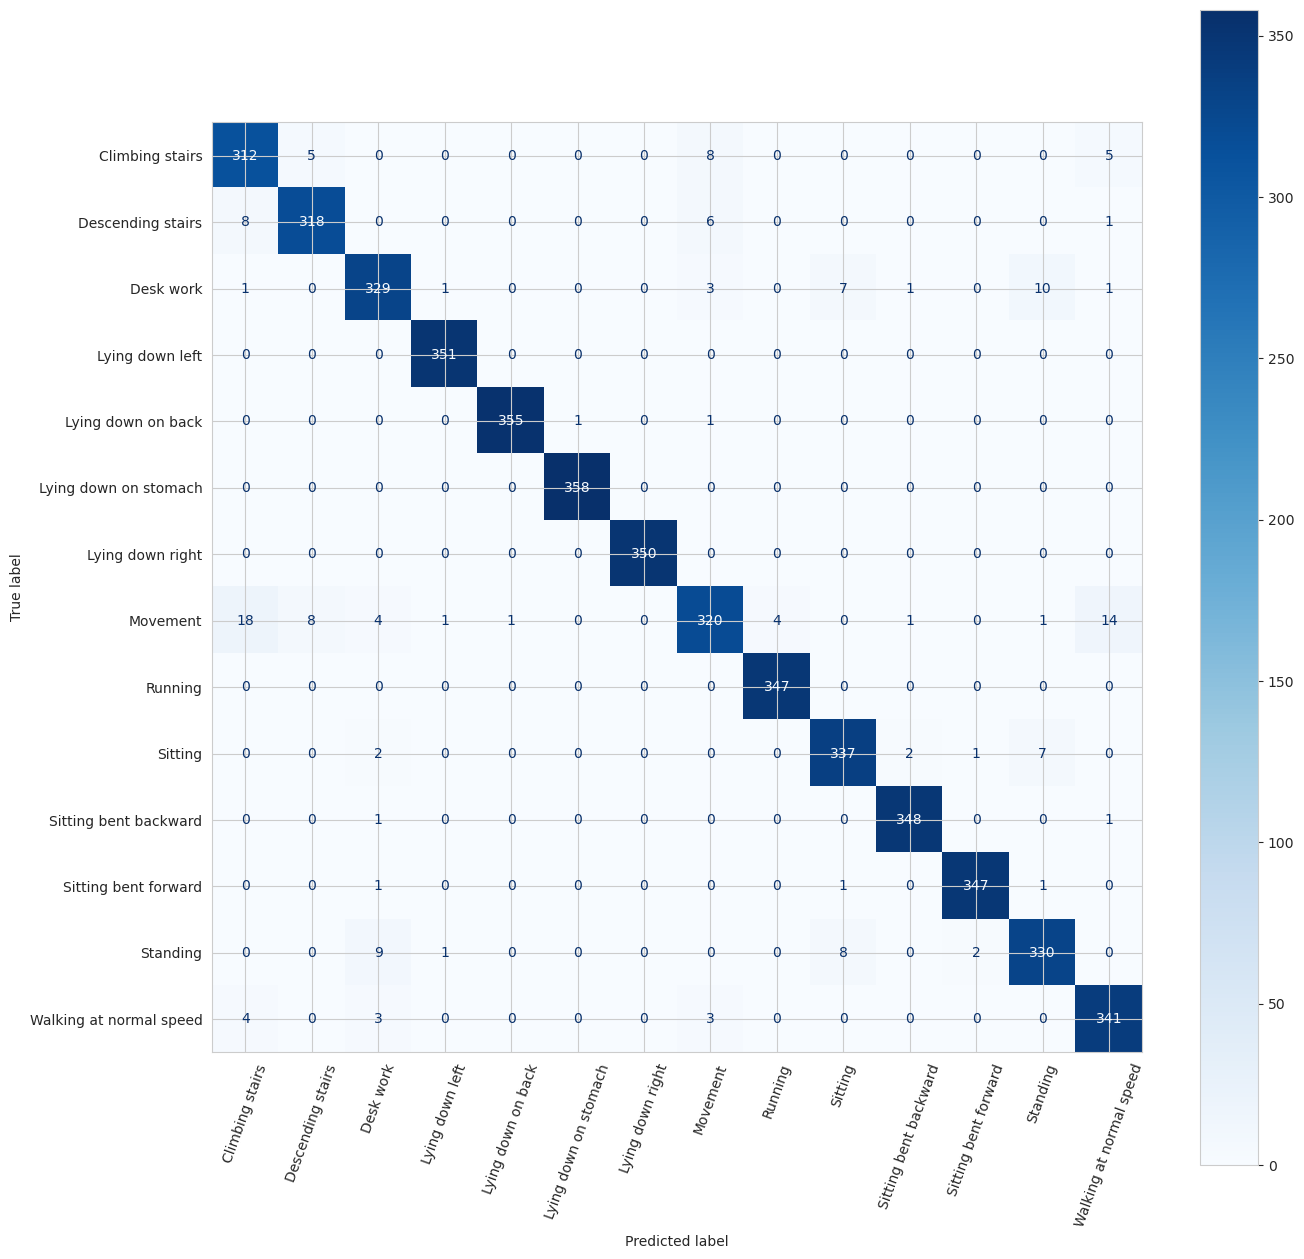

In [54]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(14, 14))
cm = confusion_matrix(
    class_labels[y_test[:, 0]],
    class_labels[y_pred.reshape(-1)],
    labels=class_labels,
)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=class_labels
).plot(cmap="Blues", xticks_rotation=70, ax=ax)

print(
    classification_report(
        class_labels[y_test[:, 0]],
        class_labels[y_pred.reshape(-1)],
        labels=class_labels,
        digits=3,
    )
)

## TF-lite conversion

In [131]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

with open('./models/HAR_transformer_2.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpi9_kbic5/assets


INFO:tensorflow:Assets written to: /tmp/tmpi9_kbic5/assets
2022-11-23 17:52:41.547542: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-23 17:52:41.547588: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-23 17:52:41.547684: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpi9_kbic5
2022-11-23 17:52:41.551644: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-23 17:52:41.551660: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpi9_kbic5
2022-11-23 17:52:41.583013: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-23 17:52:41.634711: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpi9_kbic5
2022-11-23 17:52:41.655862: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

## TF-lite Model Evaluation

In [2]:
dataset = np.load('pdiot-data/dataset.npz')
X = dataset['datapoints']
y = dataset['labels']

X, X_test, y, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1892493, stratify=y
)

print(X.shape, y.shape)
print(X_test.shape, y_test.shape)

(44106, 50, 6) (44106, 50)
(4901, 50, 6) (4901, 50)


In [3]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="./models/HAR_transformer.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

y_pred_tflite = []
for X_test_tensor in X_test:
    # Test the model on random input data.
    input_data = tf.cast(X_test_tensor, tf.float32)
    input_data = np.expand_dims(input_data, axis=0)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    #
    interpreter.invoke()
    # # The function `get_tensor()` returns a copy of the tensor data.
    # # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    y_pred_tflite.append(output_data)
y_pred_tflite = np.concatenate(y_pred_tflite, axis=0)
y_pred_tflite = y_pred_tflite.reshape(-1, y_pred_tflite.shape[-1])
y_pred_tflite = np.argmax(y_pred_tflite, axis = 1)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
2022-11-24 12:49:17.400915: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-24 12:49:17.420970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-24 12:49:17.421014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-24 12:49:17.421583: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX

In [4]:
y_test = y_test[:, 0]
idxs = []
for i in range(0, 14):
    idx = np.argwhere(y_test == i).reshape(-1)
    idxs.append(idx)

In [5]:
y_test_label = []
y_pred_label = []
for i, label_idx in enumerate(idxs):
    y_test_label.append(label_idx)
    y_pred_label.append(label_idx)

In [8]:
accuracy = {}
precision = {}
recall = {}
f1 = {}

y_test_ss = np.concatenate((y_test[y_test_label[9]], y_test[y_test_label[12]], y_test[y_test_label[10]], y_test[y_test_label[11]]))
y_pred_tflite_ss = np.concatenate((y_pred_tflite[y_pred_label[9]], y_pred_tflite[y_test_label[12]], y_pred_tflite[y_pred_label[10]], y_pred_tflite[y_test_label[11]]))
accuracy['Sitting/Standing'] = accuracy_score(y_test_ss, y_pred_tflite_ss)
precision['Sitting/Standing'] = precision_score(y_test_ss, y_pred_tflite_ss, average='weighted')
recall['Sitting/Standing'] = recall_score(y_test_ss, y_pred_tflite_ss, average='weighted', zero_division=0)
f1['Sitting/Standing'] = f1_score(y_test_ss, y_pred_tflite_ss, average='weighted')
print(f"Sitting/Standing ………………. Accuracy: {accuracy['Sitting/Standing']:>.3f}, Precision: {precision['Sitting/Standing']:>.3f}, Recall: {recall['Sitting/Standing']:>.3f}, F-score: {f1['Sitting/Standing']:>.3f}")

for i, label in enumerate(class_labels):
    if label == 'Sitting' or label == 'Standing':
        continue
    accuracy[label] = accuracy_score(y_test[y_test_label[i]], y_pred_tflite[y_pred_label[i]])
    precision[label] = precision_score(y_test[y_test_label[i]], y_pred_tflite[y_pred_label[i]], average='weighted')
    recall[label] = recall_score(y_test[y_test_label[i]], y_pred_tflite[y_pred_label[i]], average='weighted', zero_division=0)
    f1[label] = f1_score(y_test[y_test_label[i]], y_pred_tflite[y_pred_label[i]], average='weighted')
    print(f"{label} ………………. Accuracy: {accuracy[label]:>.3f}, Precision: {precision[label]:>.3f}, Recall: {recall[label]:>.3f}, F-score: {f1[label]:>.3f}")


Sitting/Standing ………………. Accuracy: 0.974, Precision: 0.984, Recall: 0.974, F-score: 0.979
Climbing stairs ………………. Accuracy: 0.945, Precision: 1.000, Recall: 0.945, F-score: 0.972
Descending stairs ………………. Accuracy: 0.955, Precision: 1.000, Recall: 0.955, F-score: 0.977
Desk work ………………. Accuracy: 0.932, Precision: 1.000, Recall: 0.932, F-score: 0.965
Lying down left ………………. Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F-score: 1.000
Lying down on back ………………. Accuracy: 0.994, Precision: 1.000, Recall: 0.994, F-score: 0.997
Lying down on stomach ………………. Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F-score: 1.000
Lying down right ………………. Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F-score: 1.000
Movement ………………. Accuracy: 0.860, Precision: 1.000, Recall: 0.860, F-score: 0.925
Running ………………. Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F-score: 1.000
Sitting bent backward ………………. Accuracy: 0.994, Precision: 1.000, Recall: 0.994, F-score: 0.997
Sitting bent forward ……

                         precision    recall  f1-score   support

        Climbing stairs      0.910     0.945     0.927       330
      Descending stairs      0.961     0.955     0.958       333
              Desk work      0.943     0.932     0.937       353
        Lying down left      0.992     1.000     0.996       351
     Lying down on back      0.997     0.994     0.996       357
  Lying down on stomach      0.997     1.000     0.999       358
       Lying down right      1.000     1.000     1.000       350
               Movement      0.938     0.860     0.898       372
                Running      0.989     1.000     0.994       347
                Sitting      0.955     0.966     0.960       349
  Sitting bent backward      0.989     0.994     0.991       350
   Sitting bent forward      0.991     0.991     0.991       350
               Standing      0.946     0.943     0.944       350
Walking at normal speed      0.939     0.972     0.955       351

               accuracy

TypeError: confusion_matrix() got an unexpected keyword argument 'digit'

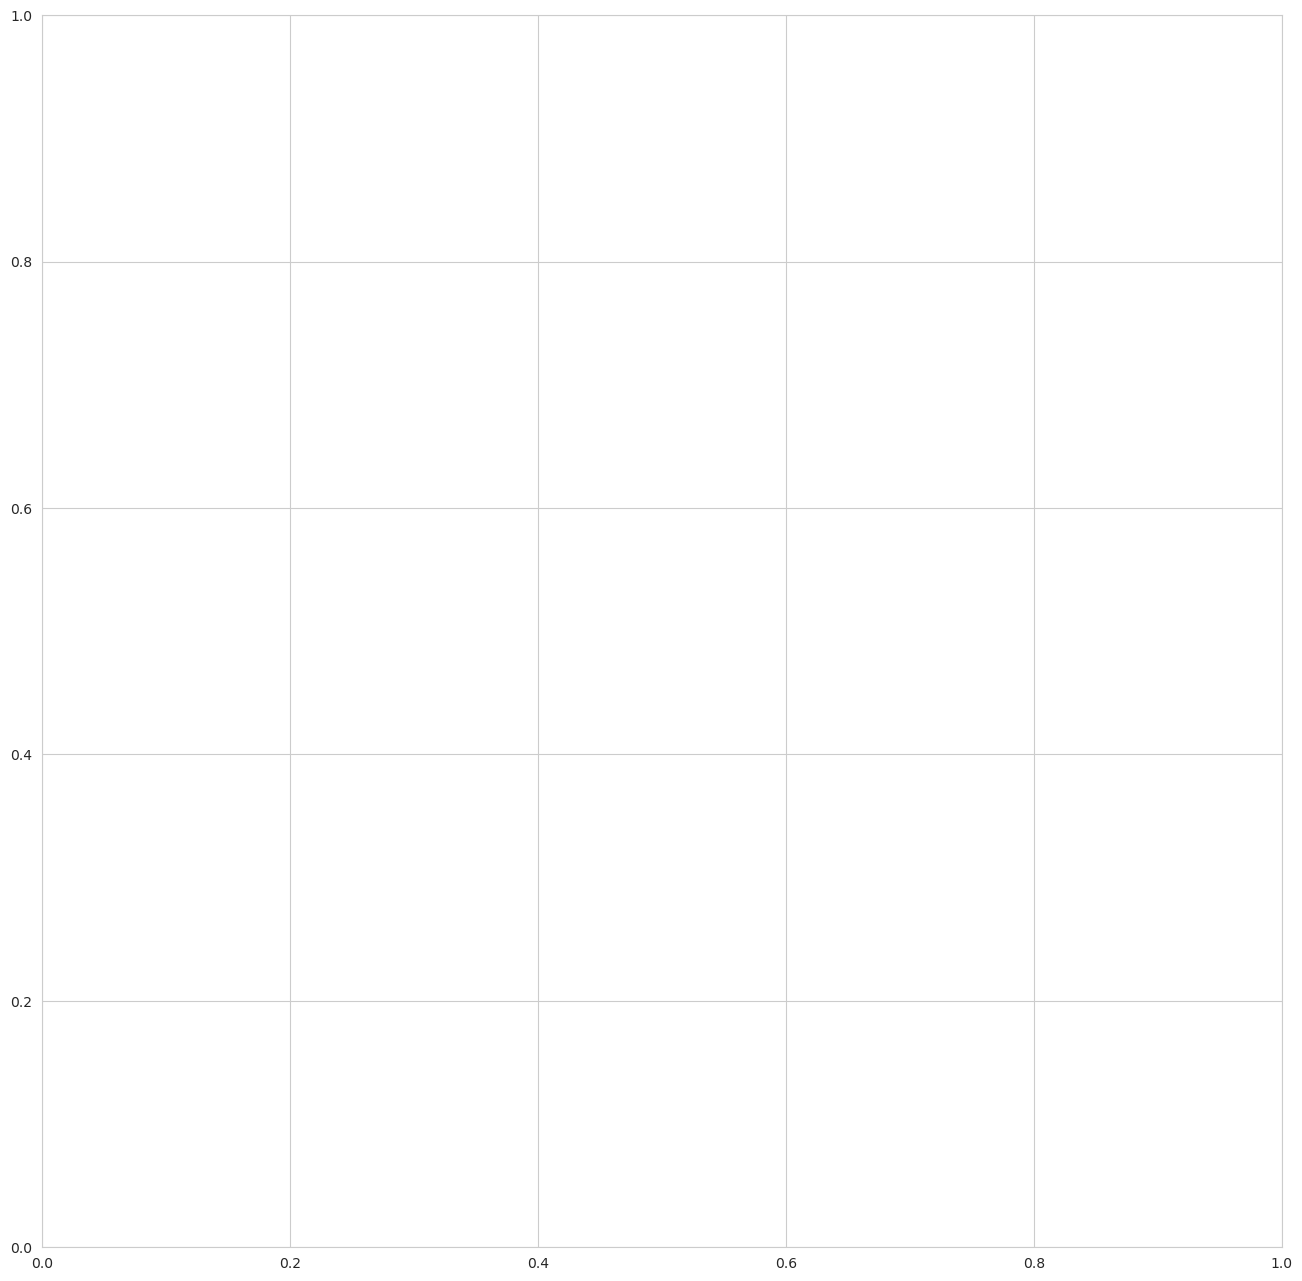

In [11]:
print(
    classification_report(
        class_labels[y_test],
        class_labels[y_pred_tflite],
        labels=class_labels,
        digits=3,
    )
)

fig, ax = plt.subplots(figsize=(16, 16))
cm = confusion_matrix(
    class_labels[y_test],
    class_labels[y_pred_tflite],
    labels=class_labels,
    normalize='true',
    digit=3
)

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_yticklabels(class_labels, rotation=0)
ax.set_xticklabels(class_labels, rotation=60)
ax.set_ylabel('True labels', fontsize=21)
ax.set_xlabel('Predicted labels', fontsize=21)
ax.collections[0].colorbar.set_label('Accuracy', fontsize=21)
fig.savefig('./confusion_matrix_model.png')

## Train with all data

In [6]:
dataset = np.load('pdiot-data/dataset.npz')
X = dataset['datapoints']
y = dataset['labels']

print(X.shape, y.shape)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=9, stratify=y
)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(49007, 50, 6) (49007, 50)
(41655, 50, 6) (41655, 50)
(7352, 50, 6) (7352, 50)


In [12]:
def final_train(config, X, y, checkpoint_filepath):
    # Generate new model
    model = Transformer(
          num_layers=config['num_layers'],
          embed_dim=config['embed_dim'],
          fc_dim=config['fc_dim'],
          num_heads=config['num_heads'],
          num_classes=config['num_classes'],
          dropout_rate=config['dropout_rate'],
          attention_dropout_rate=config['attention_dropout_rate'],
    )

    # adapt on training dataset - must be before model.compile !!!
    model.input_norm.adapt(X, batch_size=config['batch_size'])
    print(model.input_norm.variables)

    # Select optimizer
    if config['optimizer'] == "adam":
        optim = Adam(
          global_clipnorm=config['global_clipnorm'],
          amsgrad=config['amsgrad'],
        )
    else:
        raise ValueError("The used optimizer is not in list of available")

    model.compile(
        loss=smoothed_sparse_categorical_crossentropy(label_smoothing=config['label_smoothing']),
        optimizer=optim,
        metrics=["accuracy"],
    )

    # Set checkpoint callback
    checkpoint_path = checkpoint_filepath + '/' + 'final_model_checkpoint.h5'
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )

    # Train model
    model.fit(
        X_train,
        y_train,
        batch_size=config['batch_size'],
        epochs=config['epochs'],
        validation_data=(X_val, y_val),
        callbacks=[
            LearningRateScheduler(cosine_schedule(base_lr=config['learning_rate'], total_steps=config['epochs'], warmup_steps=config['warmup_steps'])),
            EarlyStopping(monitor="val_accuracy", mode='max', min_delta=0.001, patience=5),
            checkpoint_callback
        ],
        verbose=1
    )

In [14]:
with open('experiment_params/transformer_params.json') as config_file:
    config = json.load(config_file)
final_train(config, X=X, y=y, checkpoint_filepath='models/Final')

[<tf.Variable 'mean:0' shape=(6,) dtype=float32, numpy=
array([-0.0295488 , -0.62325925,  0.03363451,  0.17847902,  0.15040074,
       -0.02402629], dtype=float32)>, <tf.Variable 'variance:0' shape=(6,) dtype=float32, numpy=
array([1.9878778e-01, 2.6475504e-01, 2.5552008e-01, 2.0141632e+02,
       3.4730777e+02, 1.0190067e+02], dtype=float32)>, <tf.Variable 'count:0' shape=() dtype=int64, numpy=2450350>]
Epoch 1/80
651/651 [==============================] - 11s 15ms/step - loss: 1.8470 - accuracy: 0.5289 - val_loss: 1.4443 - val_accuracy: 0.6237 - lr: 1.0000e-04
Epoch 2/80
651/651 [==============================] - 9s 14ms/step - loss: 1.3278 - accuracy: 0.6467 - val_loss: 1.2439 - val_accuracy: 0.6770 - lr: 2.0000e-04
Epoch 3/80
651/651 [==============================] - 10s 15ms/step - loss: 1.2306 - accuracy: 0.6824 - val_loss: 1.1998 - val_accuracy: 0.7005 - lr: 3.0000e-04
Epoch 4/80
651/651 [==============================] - 13s 19ms/step - loss: 1.1740 - accuracy: 0.7132 - val_lo

In [22]:
model = create_model(config, model_path='./models/Final/final_model_checkpoint.h5')
model.build((None, 50, 6))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_4 (Transformer)  (None, 50, 14)           1395611   
                                                                 
 lambda_2 (Lambda)           (None, 14)                0         
                                                                 
 lambda_3 (Lambda)           (None, 14)                0         
                                                                 
Total params: 1,395,611
Trainable params: 1,395,598
Non-trainable params: 13
_________________________________________________________________


In [36]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

with open('./models/Final/HAR_transformer.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpxx9tf_b_/assets


INFO:tensorflow:Assets written to: /tmp/tmpxx9tf_b_/assets
2022-11-24 02:51:47.718956: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-24 02:51:47.719002: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-24 02:51:47.719109: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxx9tf_b_
2022-11-24 02:51:47.722914: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-24 02:51:47.722933: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxx9tf_b_
2022-11-24 02:51:47.740164: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-24 02:51:47.792889: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxx9tf_b_
2022-11-24 02:51:47.816585: I tensorflow/cc/saved_model/loader.cc:305] SavedModel